In [67]:
import boto3
import pandas as pd
import numpy as np
from pprint import pprint
import nltk
import tqdm.notebook as tqdm
import time
import re
import matplotlib.pyplot as plt
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [68]:
dynamo_db = boto3.resource('dynamodb')
table = dynamo_db.Table('tweets_for_sentiment') #just testing querys
athena = boto3.client('athena')

In [69]:


params = {
    'region': 'us-east-1',
    'database': 'kinesis',
    'bucket': 'cmurill5',
    'path': 'athena_results/',
    'query': 'SELECT tweet_id, user_name, text FROM "kinesis"."tweets_json";' #for academic purposes only
}


response_query_execution_id  = athena.start_query_execution(
    QueryString = params['query'],
    QueryExecutionContext = {
        'Database' : params['database']
    },
    ResultConfiguration = {
        'OutputLocation': 's3://' + params['bucket'] + '/' + params['path']
    }
)
response_get_query_details = athena.get_query_execution(
    QueryExecutionId = response_query_execution_id['QueryExecutionId']
)


for i in tqdm.tqdm(range(120)):
    response_get_query_details = athena.get_query_execution(
        QueryExecutionId = response_query_execution_id['QueryExecutionId']
    )
    status = response_get_query_details['QueryExecution']['Status']['State']
            
    if (status == 'FAILED') or (status == 'CANCELLED') :
        failure_reason = response_get_query_details['QueryExecution']['Status']['StateChangeReason']
    time.sleep(1)





In [70]:
response_query_result = athena.get_query_results(
    QueryExecutionId = response_query_execution_id['QueryExecutionId']
)

result_data = response_query_result['ResultSet']

In [71]:
header = response_query_result['ResultSet']['Rows'][0]
header = [obj['VarCharValue'] for obj in header['Data']]


In [72]:
rows = response_query_result['ResultSet']['Rows'][1:]


In [73]:
# crear datos

result = []
for row in rows:
    new_data = []
    for obj in row['Data']:
        if 'VarCharValue' in obj:
            new_data.append(obj['VarCharValue'])    
        else:
            new_data.append('')
    
    result.append(dict(zip(header,new_data)))
#crear dataframe

df = pd.DataFrame(result)
df.head()

,tweet_id,user_name,text
0,1457464340836143111,Francisco Cote,RT @VillamilBMauro: Alcalde @QuinteroCalle por...
1,1457565781747802114,Saiso ?? llorando,RT @eLPeritaAFK: El mejor alcalde @JuanSGuarni...
2,1457565785614917635,JPAS1979,"""RT @santiagoangelp: ?Que hacian divisiones de..."
3,1457565809795084289,Daniel Hernandez,"RT @Vidales2Luis: En medellin, dirigentes de @..."
4,1457565837653528584,@Pilar Blas,RT @Ccarhua2: Como una bestia atacando a mujer...


In [74]:
df['tokens'] = df['text'].apply(lambda x: nltk.word_tokenize(str(x)))
all_tokens = []
for t in df['tokens']:
    all_tokens.extend(t)
    

from nltk.corpus import stopwords
stop_words_nltk = set(stopwords.words('spanish'))

all_tokens = [re.sub(r'[^#A-Za-z0-9]+','',w) for w in all_tokens] #hashtag is important
all_tokens = [ x.lower() for x in all_tokens if x.isalpha() and len(x) > 2  and  x not in stop_words_nltk]


In [75]:
# analisis de frecuencia en palabras de 'text'
fdist = nltk.FreqDist(all_tokens)
print('Size BoW_content=',len(fdist))
topwordstitle = fdist.most_common(20)

Size BoW_content= 2531


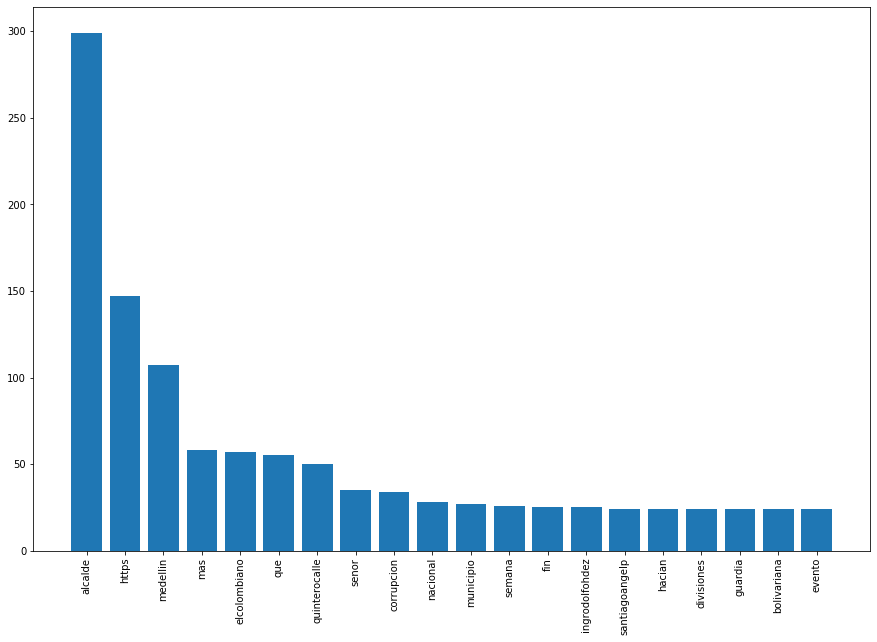

In [76]:
x,y = zip(*topwordstitle)
plt.figure(figsize=(15,10))
plt.bar(x,y)
plt.xticks(rotation=90)
plt.show()

In [77]:
df2 = pd.DataFrame(table.scan()['Items'])

In [78]:
df2['tokens'] = df2['text'].apply(lambda x: nltk.word_tokenize(str(x)))
all_tokens = []
for t in df['tokens']:
    all_tokens.extend(t)
    

from nltk.corpus import stopwords
stop_words_nltk = set(stopwords.words('spanish'))

all_tokens = [re.sub(r'[^#A-Za-z0-9]+','',w) for w in all_tokens] #hashtag is important
all_tokens = [ x.lower() for x in all_tokens if x.isalpha() and len(x) > 2  and  x not in stop_words_nltk]

Size BoW_content= 2531


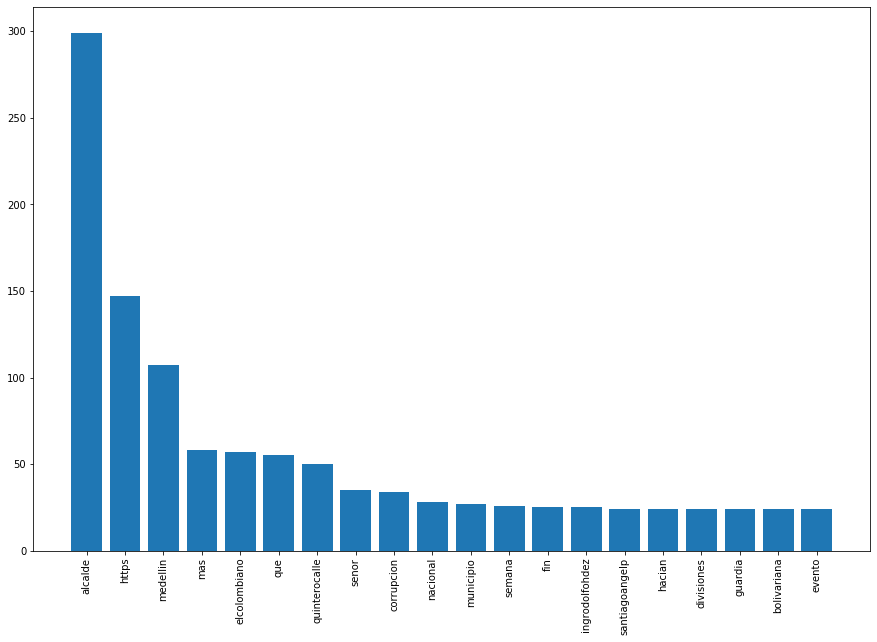

In [79]:
fdist = nltk.FreqDist(all_tokens)
print('Size BoW_content=',len(fdist))
topwordstitle = fdist.most_common(20)
x,y = zip(*topwordstitle)
plt.figure(figsize=(15,10))
plt.bar(x,y)
plt.xticks(rotation=90)
plt.show()